# Collaborative Filtering: Matrix Factorization Model

This notebook implements a matrix factorization approach for collaborative filtering to recommend courses based on user-course interactions and ratings.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse.linalg import svds
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load and Explore Data

In [30]:
# Load enrollment data
enrollments_df = pd.read_csv('../data/processed/user_course_enrollments.csv')

print(f"Total enrollments: {len(enrollments_df)}")
print(f"Unique users: {enrollments_df['user_id'].nunique()}")
print(f"Unique courses: {enrollments_df['course_index'].nunique()}")
print(f"\nRating statistics:")
print(enrollments_df['rating'].describe())
print(f"\nMatch type distribution:")
print(enrollments_df['match_type'].value_counts())
print(f"\nFirst few rows:")
enrollments_df.head(10)

Total enrollments: 3280
Unique users: 400
Unique courses: 2008

Rating statistics:
count    3280.000000
mean        3.671003
std         0.917183
min         1.000000
25%         2.997500
50%         3.945000
75%         4.382500
max         5.000000
Name: rating, dtype: float64

Match type distribution:
match_type
high      1878
random    1002
low        400
Name: count, dtype: int64

First few rows:


,user_id,course_index,course_name,match_type,rating
0,0,375,Introduction to Machine Learning,high,4.50
1,0,1330,"Merge, Sort and Filter Data in Python Pandas",high,4.24
2,0,1810,Introduction to Google Docs,high,4.56
3,0,916,Perform Real-Time Object Detection with YOLOv3,low,3.21
4,0,572,TensorFlow for AI: Computer Vision Basics,random,2.84
5,1,199,Software Product Management Capstone,high,4.21
6,1,2084,Agile Projects: Develop Product Wireframe Prot...,high,4.93
7,1,1034,Introduction to Software Product Management,high,4.61
8,1,130,Introduction to Acoustics (Part 2),low,2.02
9,1,122,World Design for Video Games,random,3.38


## 2. Build User-Item Rating Matrix

In [31]:
# Create user-item rating matrix
# Pivot the enrollments to create a matrix where rows are users and columns are courses
rating_matrix = enrollments_df.pivot(
    index='user_id',
    columns='course_index',
    values='rating'
)

print(f"Rating matrix shape: {rating_matrix.shape}")
print(f"Matrix density: {(rating_matrix.notna().sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1]) * 100):.2f}%")
print(f"\nSparsity: {(rating_matrix.isna().sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1]) * 100):.2f}%")
print(f"\nRatings per user:")
print(rating_matrix.notna().sum(axis=1).describe())
print(f"\nRatings per course:")
print(rating_matrix.notna().sum(axis=0).describe())

Rating matrix shape: (400, 2008)
Matrix density: 0.41%

Sparsity: 99.59%

Ratings per user:
count    400.000000
mean       8.200000
std        2.633884
min        4.000000
25%        6.000000
50%        8.000000
75%       10.250000
max       12.000000
dtype: float64

Ratings per course:
count    2008.000000
mean        1.633466
std         0.927956
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
dtype: float64


## 3. Train-Test Split

We'll split the data into training and test sets. Since we need to keep the matrix structure, we'll mask some ratings rather than removing rows.

In [32]:
# Split data into train and test sets
# We'll use 80-20 split
np.random.seed(42)

# Create train and test matrices
train_matrix = rating_matrix.copy()
test_matrix = rating_matrix.copy()

# For each user, randomly select 20% of their ratings for testing
test_mask = pd.DataFrame(False, index=rating_matrix.index, columns=rating_matrix.columns)

for user_id in rating_matrix.index:
    # Get the courses this user has rated
    rated_courses = rating_matrix.loc[user_id].notna()
    rated_course_indices = rated_courses[rated_courses].index.tolist()
    
    # Select 20% for testing
    n_test = max(1, int(len(rated_course_indices) * 0.2))
    test_courses = np.random.choice(rated_course_indices, size=n_test, replace=False)
    
    # Mark these for testing
    test_mask.loc[user_id, test_courses] = True
    
    # Remove from training set
    train_matrix.loc[user_id, test_courses] = np.nan

# Keep only test ratings in test matrix
test_matrix[~test_mask] = np.nan

print(f"Training set size: {train_matrix.notna().sum().sum()} ratings")
print(f"Test set size: {test_matrix.notna().sum().sum()} ratings")
print(f"Train/Test split: {train_matrix.notna().sum().sum() / (train_matrix.notna().sum().sum() + test_matrix.notna().sum().sum()) * 100:.1f}% / {test_matrix.notna().sum().sum() / (train_matrix.notna().sum().sum() + test_matrix.notna().sum().sum()) * 100:.1f}%")

Training set size: 2726 ratings
Test set size: 554 ratings
Train/Test split: 83.1% / 16.9%


## 4. Matrix Factorization using SVD

We'll use Singular Value Decomposition (SVD) to decompose the user-item rating matrix into latent factors. The key idea is:

$$R \approx U \Sigma V^T$$

Where:
- $R$ is the user-item rating matrix
- $U$ contains user latent factors
- $\Sigma$ is the diagonal matrix of singular values
- $V^T$ contains item (course) latent factors

In [33]:
# Prepare the matrix for SVD
# Fill NaN values with user mean (user-centered approach)
def normalize_matrix(matrix):
    """
    Normalize the rating matrix by subtracting user means.
    This helps the model learn relative preferences.
    """
    # Calculate mean rating for each user (only considering rated items)
    user_means = matrix.mean(axis=1)
    
    # Subtract user mean from each rating
    matrix_normalized = matrix.sub(user_means, axis=0)
    
    # Fill remaining NaN with 0 (unrated items)
    matrix_normalized = matrix_normalized.fillna(0)
    
    return matrix_normalized, user_means

# Normalize training matrix
train_normalized, user_means = normalize_matrix(train_matrix)

print(f"Normalized matrix shape: {train_normalized.shape}")
print(f"User means statistics:")
print(user_means.describe())
print(f"\nNormalized matrix sample:")
print(train_normalized.iloc[:5, :5])

Normalized matrix shape: (400, 2008)
User means statistics:
count    400.000000
mean       3.639259
std        0.456362
min        2.176667
25%        3.322437
50%        3.745000
75%        3.980000
max        4.491250
dtype: float64

Normalized matrix sample:
course_index   2    4    7    9    10
user_id                              
0             0.0  0.0  0.0  0.0  0.0
1             0.0  0.0  0.0  0.0  0.0
2             0.0  0.0  0.0  0.0  0.0
3             0.0  0.0  0.0  0.0  0.0
4             0.0  0.0  0.0  0.0  0.0


In [34]:
# Perform SVD
# We'll use k latent factors - common values are between 10-50
k = 20  # Number of latent factors

print(f"Performing SVD with {k} latent factors...")
U, sigma, Vt = svds(train_normalized.values, k=k)

# Convert sigma to diagonal matrix
sigma = np.diag(sigma)

print(f"\nU shape (user factors): {U.shape}")
print(f"Sigma shape (singular values): {sigma.shape}")
print(f"Vt shape (item factors): {Vt.shape}")
print(f"\nSingular values:")
print(np.diag(sigma))

Performing SVD with 20 latent factors...



U shape (user factors): (400, 20)
Sigma shape (singular values): (20, 20)
Vt shape (item factors): (20, 2008)

Singular values:
[3.23927739 3.24986928 3.27105764 3.29320495 3.29652812 3.30789283
 3.31840821 3.37662826 3.38509855 3.38533601 3.3887077  3.41484709
 3.4353026  3.45080515 3.48813545 3.52183598 3.5816093  3.61662553
 3.6734695  3.71371504]


In [35]:
# Reconstruct the rating matrix
predicted_ratings_normalized = np.dot(np.dot(U, sigma), Vt)

# Convert back to DataFrame
predicted_ratings_normalized_df = pd.DataFrame(
    predicted_ratings_normalized,
    index=train_matrix.index,
    columns=train_matrix.columns
)

# Add back the user means to get actual predicted ratings
predicted_ratings = predicted_ratings_normalized_df.add(user_means, axis=0)

# Clip predictions to valid rating range [1, 5]
predicted_ratings = predicted_ratings.clip(1, 5)

print("Reconstructed rating matrix:")
print(f"Shape: {predicted_ratings.shape}")
print(f"Predicted rating range: [{predicted_ratings.min().min():.2f}, {predicted_ratings.max().max():.2f}]")
print(f"\nSample predictions:")
print(predicted_ratings.iloc[:5, :5])

Reconstructed rating matrix:
Shape: (400, 2008)
Predicted rating range: [1.07, 5.00]

Sample predictions:
course_index        2         4         7         9         10
user_id                                                       
0             4.127454  4.127498  4.127500  4.127497  4.130244
1             3.635049  3.634999  3.634999  3.635001  3.633060
2             2.860284  2.862505  2.862485  2.862566  2.859668
3             3.785966  3.786000  3.786002  3.785999  3.786053
4             3.680896  3.676023  3.675992  3.675965  3.638881


## 5. Model Evaluation

In [36]:
# Evaluate on training set
train_actual = []
train_pred = []

for user_id in train_matrix.index:
    for course_id in train_matrix.columns:
        if not pd.isna(train_matrix.loc[user_id, course_id]):
            train_actual.append(train_matrix.loc[user_id, course_id])
            train_pred.append(predicted_ratings.loc[user_id, course_id])

train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))
train_mae = mean_absolute_error(train_actual, train_pred)

print("=== Training Set Performance ===")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"Number of ratings: {len(train_actual)}")

=== Training Set Performance ===
RMSE: 0.7358
MAE: 0.5708
Number of ratings: 2726


In [37]:
# Evaluate on test set
test_actual = []
test_pred = []

for user_id in test_matrix.index:
    for course_id in test_matrix.columns:
        if not pd.isna(test_matrix.loc[user_id, course_id]):
            test_actual.append(test_matrix.loc[user_id, course_id])
            test_pred.append(predicted_ratings.loc[user_id, course_id])

test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))
test_mae = mean_absolute_error(test_actual, test_pred)

print("=== Test Set Performance ===")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"Number of ratings: {len(test_actual)}")

print("\n=== Performance Summary ===")
print(f"Training RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
print(f"\nOverfitting check: {'Yes' if test_rmse > train_rmse * 1.2 else 'No'}")

=== Test Set Performance ===
RMSE: 1.0151
MAE: 0.7913
Number of ratings: 554

=== Performance Summary ===
Training RMSE: 0.7358 | Test RMSE: 1.0151
Training MAE: 0.5708 | Test MAE: 0.7913

Overfitting check: Yes


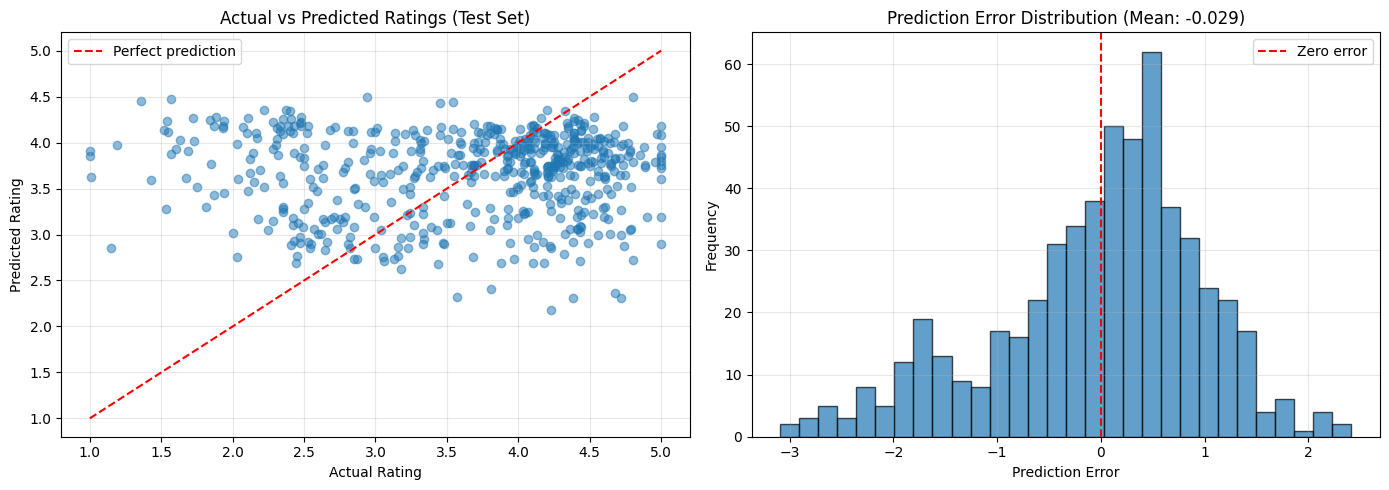


Error statistics:
Mean error: -0.0285
Std error: 1.0147


In [38]:
# Visualize prediction errors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Actual vs Predicted ratings (test set)
axes[0].scatter(test_actual, test_pred, alpha=0.5)
axes[0].plot([1, 5], [1, 5], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title('Actual vs Predicted Ratings (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Error distribution
errors = np.array(test_actual) - np.array(test_pred)
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Prediction Error Distribution (Mean: {np.mean(errors):.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError statistics:")
print(f"Mean error: {np.mean(errors):.4f}")
print(f"Std error: {np.std(errors):.4f}")

## 6. Generate Recommendations

Now we can use the predicted ratings to recommend courses to users.

In [39]:
def get_top_recommendations(user_id, n=10):
    """
    Get top N course recommendations for a user.
    Only recommend courses the user hasn't rated yet.
    """
    # Get user's predicted ratings
    user_predictions = predicted_ratings.loc[user_id]
    
    # Get courses the user has already rated
    already_rated = rating_matrix.loc[user_id].notna()
    
    # Filter out already rated courses
    unrated_predictions = user_predictions[~already_rated]
    
    # Sort by predicted rating
    top_courses = unrated_predictions.sort_values(ascending=False).head(n)
    
    return top_courses

# Test with a few users
sample_users = [0, 50, 100, 150, 200]

for user_id in sample_users:
    print(f"\n{'='*80}")
    print(f"User {user_id} - Top 5 Recommended Courses")
    print('='*80)
    
    # Get user's actual ratings
    user_ratings = rating_matrix.loc[user_id].dropna()
    print(f"User has rated {len(user_ratings)} courses")
    print(f"Average rating given: {user_ratings.mean():.2f}")
    
    # Get recommendations
    recommendations = get_top_recommendations(user_id, n=5)
    
    print("\nTop 5 Recommendations:")
    for rank, (course_idx, pred_rating) in enumerate(recommendations.items(), 1):
        course_name = enrollments_df[enrollments_df['course_index'] == course_idx]['course_name'].iloc[0]
        print(f"{rank}. {course_name[:70]}")
        print(f"   Predicted Rating: {pred_rating:.2f}")


User 0 - Top 5 Recommended Courses
User has rated 5 courses
Average rating given: 3.87

Top 5 Recommendations:
1. Competitive Strategy
   Predicted Rating: 4.14
2. The Business of Social
   Predicted Rating: 4.14
3. Agile Projects:  Developing Tasks with Taiga
   Predicted Rating: 4.13
4. Ethical Social Media
   Predicted Rating: 4.13
5. Hiring and Onboarding Employees with ClickUp
   Predicted Rating: 4.13

User 50 - Top 5 Recommended Courses
User has rated 5 courses
Average rating given: 3.53

Top 5 Recommendations:
1. Analyze Stock Data using R and Quantmod Package
   Predicted Rating: 3.35
2. Java Programming: Solving Problems with Software
   Predicted Rating: 3.35
3. Build a Google Firebase Web Application
   Predicted Rating: 3.35
4. Business Transformation with Google Cloud
   Predicted Rating: 3.35
5. Introduction to Structured Query Language (SQL)
   Predicted Rating: 3.35

User 100 - Top 5 Recommended Courses
User has rated 8 courses
Average rating given: 3.99

Top 5 Recomm

## 6.2. Ranking Metrics: NDCG@k and Precision@k

These metrics evaluate the quality of recommendation rankings, which is more relevant than rating prediction for recommendation systems.

In [40]:
def dcg_at_k(relevance_scores, k):
    """
    Calculate Discounted Cumulative Gain at k.
    DCG = sum(rel_i / log2(i+1)) for i in 1..k
    """
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    # Positions start at 1, so we use i+2 for log2(i+1)
    discounts = np.log2(np.arange(2, relevance_scores.size + 2))
    return np.sum(relevance_scores / discounts)

def ndcg_at_k(relevance_scores, k):
    """
    Calculate Normalized Discounted Cumulative Gain at k.
    NDCG = DCG / IDCG (ideal DCG with perfect ranking)
    """
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = dcg_at_k(ideal_relevance, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

def precision_at_k(relevance_scores, k):
    """
    Calculate Precision at k.
    Precision@k = (# relevant items in top-k) / k
    """
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    return np.sum(relevance_scores > 0) / k

print("Ranking metric functions defined successfully")

Ranking metric functions defined successfully


In [43]:
# Evaluate ranking metrics on test set
# For each user, we'll rank courses by predicted rating and measure how well
# high-rated courses appear at the top

def evaluate_ranking_metrics(k_values=[5, 10, 20]):
    """
    Evaluate NDCG@k and Precision@k for different k values.
    Relevance is based on actual ratings: rating >= 4.0 is relevant (1), else not relevant (0)
    """
    all_ndcg = {k: [] for k in k_values}
    all_precision = {k: [] for k in k_values}
    
    for user_id in test_matrix.index:
        # Get test ratings for this user
        user_test_ratings = test_matrix.loc[user_id].dropna()
        
        if len(user_test_ratings) == 0:
            continue
        
        # Get predicted ratings for these test courses
        user_predictions = predicted_ratings.loc[user_id, user_test_ratings.index]
        
        # Sort courses by predicted rating (descending)
        sorted_indices = user_predictions.sort_values(ascending=False).index
        
        # Get actual ratings in the order of predictions
        actual_ratings_sorted = user_test_ratings[sorted_indices].values
        
        # Binary relevance: 1 if rating >= 4.0 (good course), 0 otherwise
        relevance = (actual_ratings_sorted >= 4.0).astype(float)
        
        # Calculate metrics for different k values
        # Use min(k, len(relevance)) to handle users with fewer than k test ratings
        for k in k_values:
            if len(relevance) > 0:  # Only need at least 1 rating
                all_ndcg[k].append(ndcg_at_k(relevance, k))
                all_precision[k].append(precision_at_k(relevance, k))
    
    # Calculate mean metrics
    results = {}
    for k in k_values:
        results[k] = {
            'ndcg': np.mean(all_ndcg[k]) if all_ndcg[k] else 0.0,
            'precision': np.mean(all_precision[k]) if all_precision[k] else 0.0,
            'n_users': len(all_ndcg[k])
        }
    
    return results

# Evaluate for k = 5, 10, 20
ranking_results = evaluate_ranking_metrics(k_values=[5, 10, 20])

print("=== RANKING METRICS (Test Set) ===")
print("\nRelevance Definition: Courses with rating >= 4.0 are considered relevant\n")
for k, metrics in ranking_results.items():
    print(f"k = {k}:")
    print(f"  NDCG@{k}:      {metrics['ndcg']:.4f}")
    print(f"  Precision@{k}: {metrics['precision']:.4f}")
    print(f"  Users evaluated: {metrics['n_users']}")
    print()

=== RANKING METRICS (Test Set) ===

Relevance Definition: Courses with rating >= 4.0 are considered relevant

k = 5:
  NDCG@5:      0.5294
  Precision@5: 0.1310
  Users evaluated: 400

k = 10:
  NDCG@10:      0.5294
  Precision@10: 0.0655
  Users evaluated: 400

k = 20:
  NDCG@20:      0.5294
  Precision@20: 0.0328
  Users evaluated: 400



## 6.3. Explanation Generation

Generate human-readable explanations for why courses are recommended.

In [44]:
# Load course and user data for generating explanations
courses_df = pd.read_csv('../data/processed/coursera_cleaned.csv')

# Load user-course enrollments with match types
enrollments_with_match = enrollments_df.copy()

def generate_explanation(user_id, course_idx, predicted_rating, actual_rating=None):
    """
    Generate human-readable explanation for why a course is recommended.
    Uses collaborative filtering logic + course metadata.
    """
    # Get course information
    if course_idx < len(courses_df):
        course_info = courses_df.iloc[course_idx]
    else:
        # Fallback if index out of bounds
        return {
            'course_name': f'Course {course_idx}',
            'predicted_rating': predicted_rating,
            'actual_rating': actual_rating,
            'explanation_text': [f"⚠️ Course information not available. Predicted rating: {predicted_rating:.2f}/5.0"]
        }
    
    course_name = course_info['Course Name']
    course_skills = course_info['skills_cleaned'].split('  ') if pd.notna(course_info['skills_cleaned']) else []
    difficulty = course_info['Difficulty Level']
    
    # Get similar users who rated this course highly
    course_col_position = list(rating_matrix.columns).index(course_idx) if course_idx in rating_matrix.columns else None
    if course_col_position is not None:
        course_ratings = rating_matrix.iloc[:, course_col_position].dropna()
        high_raters = course_ratings[course_ratings >= 4.0]
    else:
        high_raters = []
    
    # Get user's rating pattern
    user_ratings = rating_matrix.loc[user_id].dropna()
    user_avg_rating = user_ratings.mean()
    
    # Build explanation components
    explanation = {
        'course_name': course_name,
        'predicted_rating': predicted_rating,
        'actual_rating': actual_rating,
        'difficulty': difficulty,
        'skills': course_skills[:5],  # Top 5 skills
        'similar_users_liked': len(high_raters),
        'your_avg_rating': user_avg_rating,
        'explanation_text': []
    }
    
    # Generate explanation text
    if predicted_rating >= 4.5:
        explanation['explanation_text'].append(f"✨ Highly recommended! Predicted rating: {predicted_rating:.2f}/5.0")
    elif predicted_rating >= 4.0:
        explanation['explanation_text'].append(f"👍 Good match! Predicted rating: {predicted_rating:.2f}/5.0")
    elif predicted_rating >= 3.5:
        explanation['explanation_text'].append(f"👌 Decent match. Predicted rating: {predicted_rating:.2f}/5.0")
    else:
        explanation['explanation_text'].append(f"⚠️ Moderate match. Predicted rating: {predicted_rating:.2f}/5.0")
    
    if len(high_raters) > 0:
        explanation['explanation_text'].append(f"📊 {len(high_raters)} users with similar preferences rated this course 4+ stars")
    
    explanation['explanation_text'].append(f"📚 Difficulty: {difficulty}")
    
    if len(course_skills) > 0:
        skills_text = ", ".join(course_skills[:3])
        explanation['explanation_text'].append(f"🎯 Key skills: {skills_text}")
    
    # Compare to user's average
    if predicted_rating > user_avg_rating + 0.5:
        explanation['explanation_text'].append(f"⭐ This course is predicted to be better than your average rating ({user_avg_rating:.2f})")
    
    return explanation

# Test explanation generation
print("=== EXPLANATION GENERATION EXAMPLES ===\n")
sample_user = 0
recommendations = get_top_recommendations(sample_user, n=3)

for rank, (course_idx, pred_rating) in enumerate(recommendations.items(), 1):
    print(f"\n{'-'*80}")
    print(f"Recommendation #{rank}")
    print('-'*80)
    
    explanation = generate_explanation(sample_user, course_idx, pred_rating)
    
    print(f"\nCourse: {explanation['course_name']}")
    print(f"\nExplanation:")
    for text in explanation['explanation_text']:
        print(f"  • {text}")
    print()

=== EXPLANATION GENERATION EXAMPLES ===


--------------------------------------------------------------------------------
Recommendation #1
--------------------------------------------------------------------------------

Course: Competitive Strategy

Explanation:
  • 👍 Good match! Predicted rating: 4.14/5.0
  • 📊 3 users with similar preferences rated this course 4+ stars
  • 📚 Difficulty: Beginner
  • 🎯 Key skills: competitiveness, leadership and management, game theory


--------------------------------------------------------------------------------
Recommendation #2
--------------------------------------------------------------------------------

Course: The Business of Social

Explanation:
  • 👍 Good match! Predicted rating: 4.14/5.0
  • 📊 3 users with similar preferences rated this course 4+ stars
  • 📚 Difficulty: Intermediate
  • 🎯 Key skills: social media marketing, social media, media market


--------------------------------------------------------------------------------


## 6.4. Simulated User Engagement Metrics

Simulate user engagement based on recommendation quality and match types.

In [45]:
def simulate_user_engagement(predicted_rating, actual_rating=None, match_type=None):
    """
    Simulate user engagement metrics based on recommendation quality.
    
    Returns:
    - click_through_rate: Probability user clicks on recommendation
    - acceptance_rate: Probability user enrolls after clicking
    - satisfaction_score: Simulated user satisfaction (1-5)
    """
    np.random.seed(None)  # Use true randomness for simulation
    
    # Base probabilities
    base_ctr = 0.15  # 15% baseline click-through rate
    base_acceptance = 0.30  # 30% baseline acceptance rate
    
    # Adjust based on predicted rating (higher rating = higher engagement)
    rating_boost = (predicted_rating - 3.0) * 0.15  # Each star above 3 adds 15%
    
    # Calculate click-through rate (0-100%)
    ctr = min(1.0, max(0.05, base_ctr + rating_boost + np.random.normal(0, 0.05)))
    
    # Calculate acceptance rate (conditional on click)
    acceptance = min(1.0, max(0.10, base_acceptance + rating_boost + np.random.normal(0, 0.08)))
    
    # If we have actual rating, use it to determine satisfaction
    if actual_rating is not None:
        # Satisfaction based on how well prediction matched reality
        prediction_error = abs(predicted_rating - actual_rating)
        satisfaction = max(1.0, min(5.0, actual_rating - prediction_error * 0.5 + np.random.normal(0, 0.3)))
    else:
        # Otherwise base on predicted rating
        satisfaction = max(1.0, min(5.0, predicted_rating + np.random.normal(0, 0.4)))
    
    # Adjust based on match type if available
    if match_type == 'high':
        ctr *= 1.2
        acceptance *= 1.3
        satisfaction = min(5.0, satisfaction * 1.1)
    elif match_type == 'low':
        ctr *= 0.7
        acceptance *= 0.6
        satisfaction = max(1.0, satisfaction * 0.8)
    
    return {
        'click_through_rate': ctr,
        'acceptance_rate': acceptance,
        'satisfaction_score': satisfaction,
        'overall_conversion': ctr * acceptance  # Clicked AND enrolled
    }

# Simulate engagement for all test recommendations
print("=== SIMULATED USER ENGAGEMENT METRICS ===\n")

all_engagements = []

for user_id in test_matrix.index[:50]:  # Sample 50 users
    # Get test ratings for this user
    user_test_ratings = test_matrix.loc[user_id].dropna()
    
    if len(user_test_ratings) == 0:
        continue
    
    # Get top 10 recommendations
    recommendations = get_top_recommendations(user_id, n=10)
    
    for course_idx, pred_rating in recommendations.items():
        # Check if this course is in test set
        actual_rating = test_matrix.loc[user_id, course_idx] if course_idx in user_test_ratings.index else None
        
        # Get match type from original enrollments if available
        user_enrollments = enrollments_df[
            (enrollments_df['user_id'] == user_id) & 
            (enrollments_df['course_index'] == course_idx)
        ]
        match_type = user_enrollments['match_type'].iloc[0] if len(user_enrollments) > 0 else None
        
        # Simulate engagement
        engagement = simulate_user_engagement(pred_rating, actual_rating, match_type)
        engagement['user_id'] = user_id
        engagement['course_idx'] = course_idx
        engagement['predicted_rating'] = pred_rating
        engagement['actual_rating'] = actual_rating
        engagement['match_type'] = match_type
        
        all_engagements.append(engagement)

# Convert to DataFrame for analysis
engagement_df = pd.DataFrame(all_engagements)

print("Engagement Metrics Summary:")
print(f"Number of recommendations analyzed: {len(engagement_df)}")
print(f"\nAverage Metrics:")
print(f"  Click-Through Rate (CTR): {engagement_df['click_through_rate'].mean():.2%}")
print(f"  Acceptance Rate: {engagement_df['acceptance_rate'].mean():.2%}")
print(f"  Overall Conversion Rate: {engagement_df['overall_conversion'].mean():.2%}")
print(f"  Satisfaction Score: {engagement_df['satisfaction_score'].mean():.2f}/5.0")

# Breakdown by match type
print(f"\n{'='*60}")
print("ENGAGEMENT BY MATCH TYPE")
print('='*60)

for match_type in ['high', 'random', 'low']:
    match_data = engagement_df[engagement_df['match_type'] == match_type]
    if len(match_data) > 0:
        print(f"\n{match_type.upper()} MATCH ({len(match_data)} recommendations):")
        print(f"  CTR: {match_data['click_through_rate'].mean():.2%}")
        print(f"  Acceptance: {match_data['acceptance_rate'].mean():.2%}")
        print(f"  Conversion: {match_data['overall_conversion'].mean():.2%}")
        print(f"  Satisfaction: {match_data['satisfaction_score'].mean():.2f}/5.0")

# Breakdown by predicted rating bins
print(f"\n{'='*60}")
print("ENGAGEMENT BY PREDICTED RATING")
print('='*60)

engagement_df['rating_bin'] = pd.cut(engagement_df['predicted_rating'], 
                                       bins=[0, 3.5, 4.0, 4.5, 5.0], 
                                       labels=['< 3.5', '3.5-4.0', '4.0-4.5', '4.5+'])

for rating_bin in ['< 3.5', '3.5-4.0', '4.0-4.5', '4.5+']:
    bin_data = engagement_df[engagement_df['rating_bin'] == rating_bin]
    if len(bin_data) > 0:
        print(f"\nPredicted Rating {rating_bin} ({len(bin_data)} recommendations):")
        print(f"  CTR: {bin_data['click_through_rate'].mean():.2%}")
        print(f"  Acceptance: {bin_data['acceptance_rate'].mean():.2%}")
        print(f"  Conversion: {bin_data['overall_conversion'].mean():.2%}")
        print(f"  Satisfaction: {bin_data['satisfaction_score'].mean():.2f}/5.0")

=== SIMULATED USER ENGAGEMENT METRICS ===

Engagement Metrics Summary:
Number of recommendations analyzed: 500

Average Metrics:
  Click-Through Rate (CTR): 25.09%
  Acceptance Rate: 39.99%
  Overall Conversion Rate: 10.49%
  Satisfaction Score: 3.66/5.0

ENGAGEMENT BY MATCH TYPE

ENGAGEMENT BY PREDICTED RATING

Predicted Rating < 3.5 (159 recommendations):
  CTR: 15.71%
  Acceptance: 31.06%
  Conversion: 5.02%
  Satisfaction: 3.01/5.0

Predicted Rating 3.5-4.0 (182 recommendations):
  CTR: 27.37%
  Acceptance: 42.11%
  Conversion: 11.51%
  Satisfaction: 3.80/5.0

Predicted Rating 4.0-4.5 (158 recommendations):
  CTR: 31.80%
  Acceptance: 46.45%
  Conversion: 14.74%
  Satisfaction: 4.16/5.0

Predicted Rating 4.5+ (1 recommendations):
  CTR: 41.96%
  Acceptance: 50.59%
  Conversion: 21.23%
  Satisfaction: 5.00/5.0


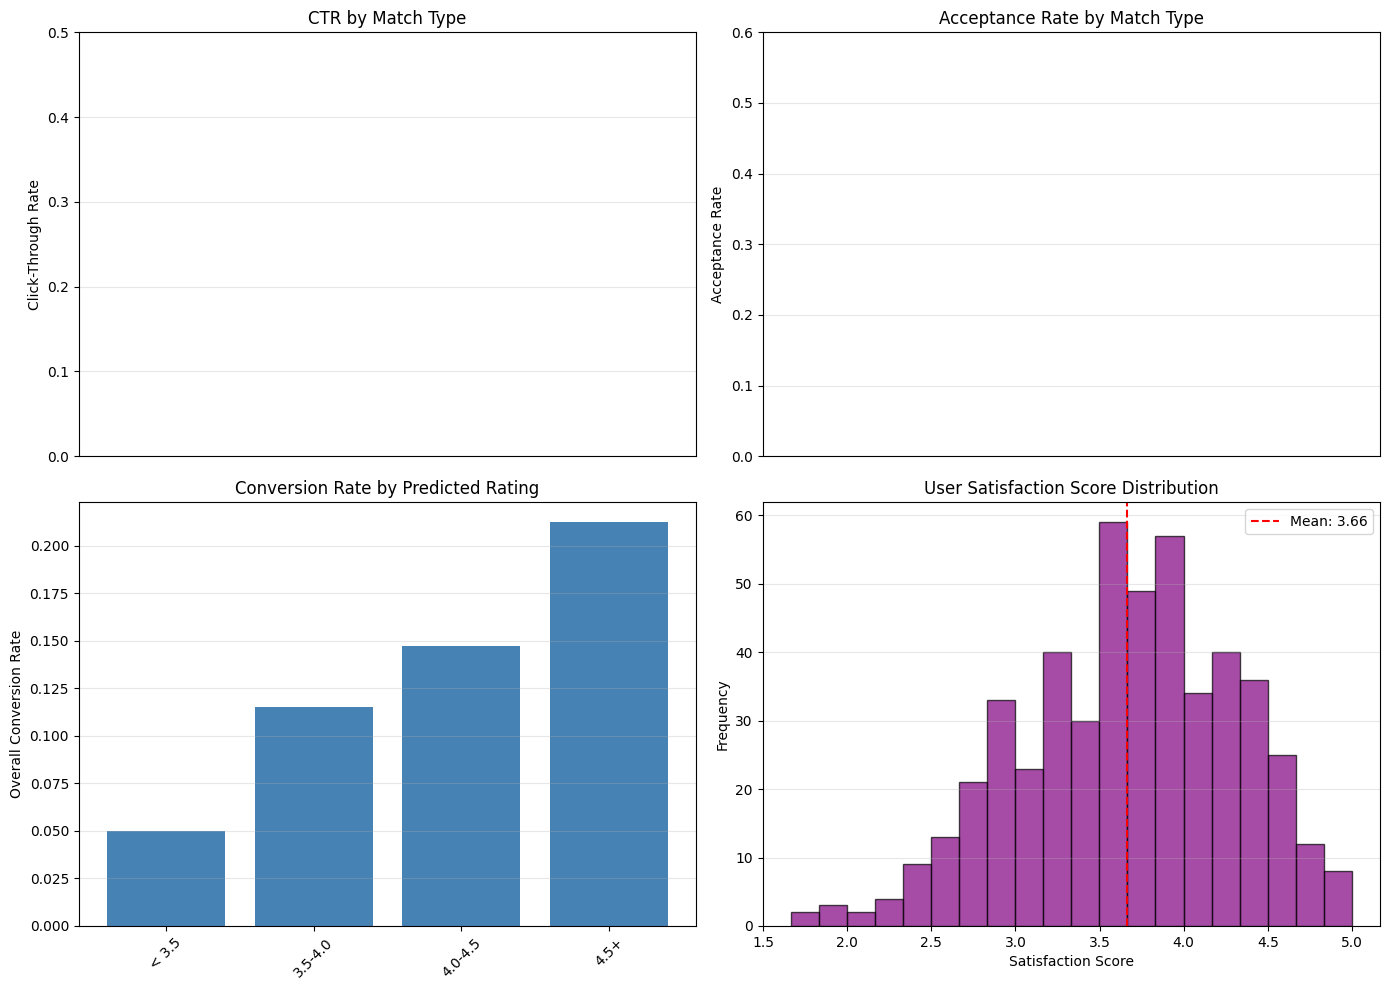


✅ Engagement metrics visualization complete


In [46]:
# Visualize engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: CTR by match type
match_ctr = engagement_df.groupby('match_type')['click_through_rate'].mean().sort_values(ascending=False)
axes[0, 0].bar(range(len(match_ctr)), match_ctr.values, color=['green', 'orange', 'red'])
axes[0, 0].set_xticks(range(len(match_ctr)))
axes[0, 0].set_xticklabels(match_ctr.index, rotation=0)
axes[0, 0].set_ylabel('Click-Through Rate')
axes[0, 0].set_title('CTR by Match Type')
axes[0, 0].set_ylim([0, 0.5])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Acceptance rate by match type
match_acceptance = engagement_df.groupby('match_type')['acceptance_rate'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(match_acceptance)), match_acceptance.values, color=['green', 'orange', 'red'])
axes[0, 1].set_xticks(range(len(match_acceptance)))
axes[0, 1].set_xticklabels(match_acceptance.index, rotation=0)
axes[0, 1].set_ylabel('Acceptance Rate')
axes[0, 1].set_title('Acceptance Rate by Match Type')
axes[0, 1].set_ylim([0, 0.6])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Overall conversion by predicted rating
rating_conversion = engagement_df.groupby('rating_bin')['overall_conversion'].mean()
axes[1, 0].bar(range(len(rating_conversion)), rating_conversion.values, color='steelblue')
axes[1, 0].set_xticks(range(len(rating_conversion)))
axes[1, 0].set_xticklabels(rating_conversion.index, rotation=45)
axes[1, 0].set_ylabel('Overall Conversion Rate')
axes[1, 0].set_title('Conversion Rate by Predicted Rating')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Satisfaction score distribution
axes[1, 1].hist(engagement_df['satisfaction_score'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(x=engagement_df['satisfaction_score'].mean(), color='r', linestyle='--', 
                   label=f"Mean: {engagement_df['satisfaction_score'].mean():.2f}")
axes[1, 1].set_xlabel('Satisfaction Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('User Satisfaction Score Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Engagement metrics visualization complete")

## 7. Save Model Artifacts

In [47]:
# Save model components and evaluation metrics
model_artifacts = {
    'U': U,
    'sigma': sigma,
    'Vt': Vt,
    'user_means': user_means.to_dict(),
    'user_ids': list(rating_matrix.index),
    'course_ids': list(rating_matrix.columns),
    'k': k
}

# Save comprehensive metadata including new metrics
metadata = {
    'model_type': 'SVD Matrix Factorization',
    'latent_factors': k,
    'train_rmse': float(train_rmse),
    'train_mae': float(train_mae),
    'test_rmse': float(test_rmse),
    'test_mae': float(test_mae),
    'n_users': len(rating_matrix.index),
    'n_courses': len(rating_matrix.columns),
    'n_train_ratings': len(train_actual),
    'n_test_ratings': len(test_actual),
    # Add ranking metrics
    'ranking_metrics': {
        f'ndcg@{k}': float(metrics['ndcg'])
        for k, metrics in ranking_results.items()
    },
    'precision_metrics': {
        f'precision@{k}': float(metrics['precision'])
        for k, metrics in ranking_results.items()
    },
    # Add engagement metrics
    'engagement_metrics': {
        'avg_click_through_rate': float(engagement_df['click_through_rate'].mean()),
        'avg_acceptance_rate': float(engagement_df['acceptance_rate'].mean()),
        'avg_conversion_rate': float(engagement_df['overall_conversion'].mean()),
        'avg_satisfaction_score': float(engagement_df['satisfaction_score'].mean())
    },
    'trained_at': datetime.now().isoformat()
}

# Save files
model_path = '../models/collaborative/svd_model.joblib'
metadata_path = '../models/collaborative/svd_metadata.json'

import os
os.makedirs('../models/collaborative', exist_ok=True)

joblib.dump(model_artifacts, model_path)
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Model saved to: {model_path}")
print(f"Metadata saved to: {metadata_path}")
print("\n=== COMPLETE MODEL SUMMARY ===")
print("\nRating Prediction Metrics:")
print(f"  Training RMSE: {train_rmse:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print("\nRanking Metrics:")
for k, metrics in ranking_results.items():
    print(f"  NDCG@{k}: {metrics['ndcg']:.4f}")
    print(f"  Precision@{k}: {metrics['precision']:.4f}")
print("\nEngagement Metrics (Simulated):")
print(f"  Click-Through Rate: {engagement_df['click_through_rate'].mean():.2%}")
print(f"  Acceptance Rate: {engagement_df['acceptance_rate'].mean():.2%}")
print(f"  Overall Conversion: {engagement_df['overall_conversion'].mean():.2%}")
print(f"  User Satisfaction: {engagement_df['satisfaction_score'].mean():.2f}/5.0")

Model saved to: ../models/collaborative/svd_model.joblib
Metadata saved to: ../models/collaborative/svd_metadata.json

=== COMPLETE MODEL SUMMARY ===

Rating Prediction Metrics:
  Training RMSE: 0.7358
  Test RMSE: 1.0151
  Test MAE: 0.7913

Ranking Metrics:
  NDCG@5: 0.5294
  Precision@5: 0.1310
  NDCG@10: 0.5294
  Precision@10: 0.0655
  NDCG@20: 0.5294
  Precision@20: 0.0328

Engagement Metrics (Simulated):
  Click-Through Rate: 25.09%
  Acceptance Rate: 39.99%
  Overall Conversion: 10.49%
  User Satisfaction: 3.66/5.0
